In [1]:
options(warn=-1)
library(statsecol)
library(jagsUI)

In [2]:
data(falcons)
str(falcons)

'data.frame':	40 obs. of  5 variables:
 $ Year  : int  1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 ...
 $ Yr    : num  0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 ...
 $ PairsT: int  34 45 39 36 20 18 21 20 17 20 ...
 $ PairsR: int  19 18 22 19 8 7 9 11 10 12 ...
 $ Young : int  27 30 36 37 19 10 9 17 15 23 ...


── Attaching packages ───────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



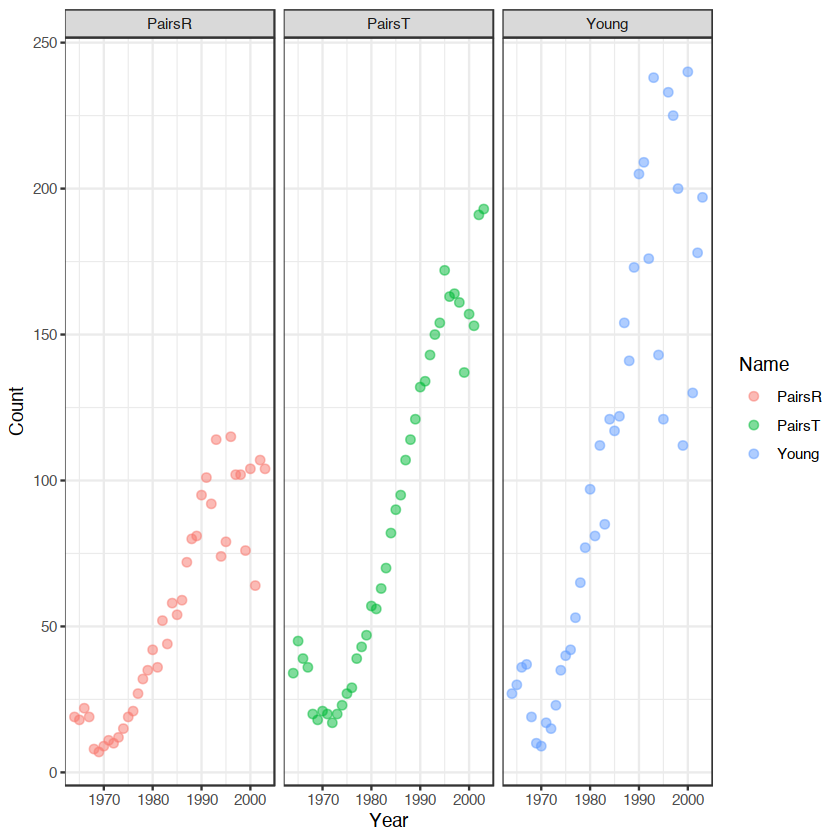

In [3]:
library(tidyverse)
library(ggplot2)
falcons %>%
 pivot_longer(names_to = "Name",
              values_to = "Count",
              cols = c(3,4,5)) %>%
 ggplot(aes(x=Year,y=Count, color=Name)) +
  geom_point(size=2, alpha=0.5) +
  facet_wrap(.~Name) +
  theme_bw()

In [10]:
sink("GLM_Poisson.txt")
cat("
model{ #tell JAGS this is the model

  # Specify the Priors
  beta0 ~ dnorm(0, 0.001) #JAGS wants precision
  beta1 ~ dnorm(0, 0.001) # which is 1/sd
  beta2 ~ dnorm(0, 0.001)

  # Define the likelihood
  for (i in 1:n){
    C[i] ~ dbinom(p[i], N[i])                # 1. Probability model for data
    logit(p[i]) <- logit.p[i]          # 2. Link function
    logit.p[i] <- beta0 + beta1 * year[i] + beta2 * year[i]^2 # 3. Linear predictor
  }
}
",fill=TRUE)
sink()


model{ #tell JAGS this is the model

  # Specify the Priors
  beta0 ~ dnorm(0, 0.001) #JAGS wants precision
  beta1 ~ dnorm(0, 0.001) # which is 1/sd
  beta2 ~ dnorm(0, 0.001)

  # Define the likelihood
  for (i in 1:n){
    C[i] ~ dbinom(p[i], N[i])                # 1. Probability model for data
    logit(p[i]) <- logit.p[i]          # 2. Link function
    logit.p[i] <- beta0 + beta1 * year[i] + beta2 * year[i]^2 # 3. Linear predictor
  }
}



In [5]:
jagsdat <- list(
    n = nrow(falcons), 
    C = falcons$PairsR,
    N = falcons$PairsT,
    year = falcons$Yr
)

In [6]:
inits <- function(){
  list(beta0 = runif(1, -2, 2), #random number between -2 and 2
       beta1 = runif(1, -2, 2),
       beta2 = runif(1, -2, 2)) #random number between -2 and 2
}

In [7]:
parms <- c("beta0","beta1", "beta2", "p")

In [8]:
nc <- 3
nb <- 1000
ni <- 5000 + nb
nt <- 1

In [12]:
out <- jags(
    data = jagsdat,
    inits = inits,
    parameters.to.save = parms,
    model.file = "GLM_Poisson.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)


Processing function input....... 

Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 327

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 1000 iterations x 3 chains 
 

Sampling from joint posterior, 5000 iterations x 3 chains 
 

Calculating statistics....... 

Done. 


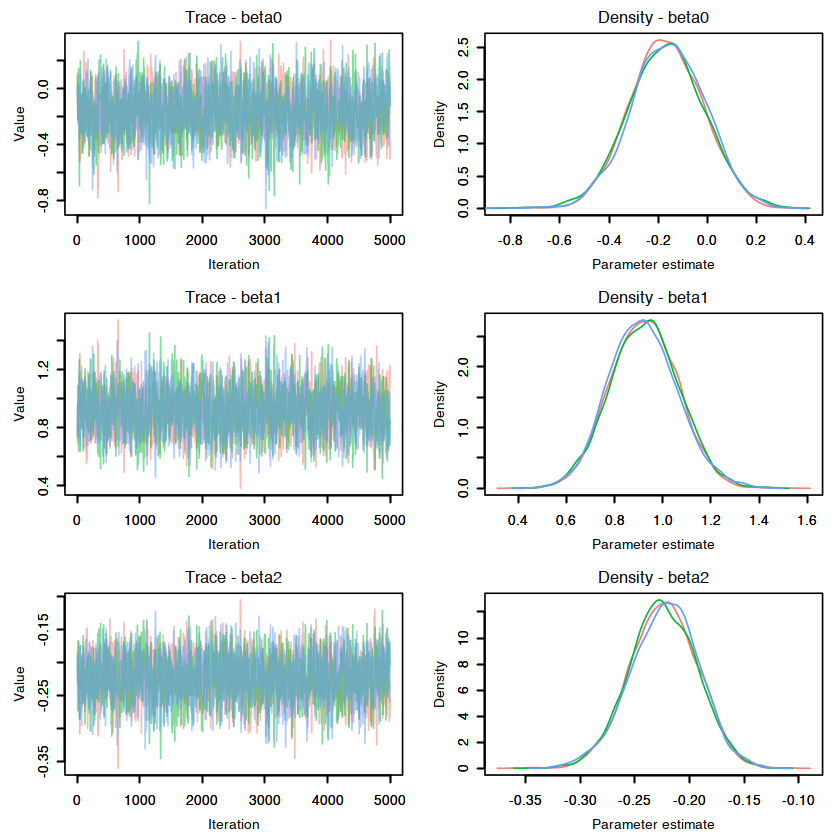

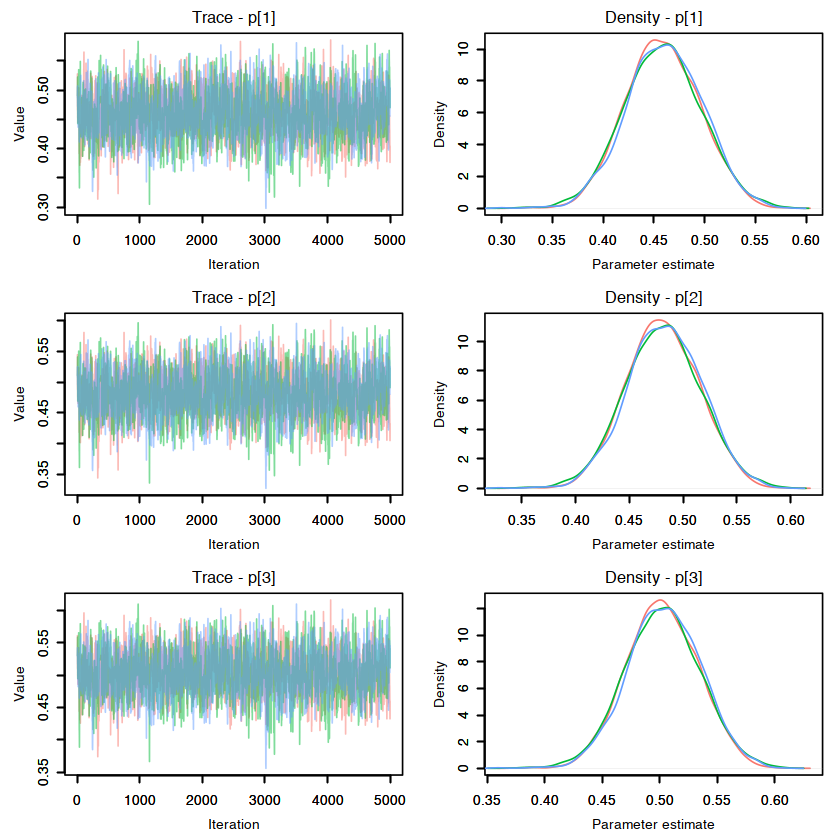

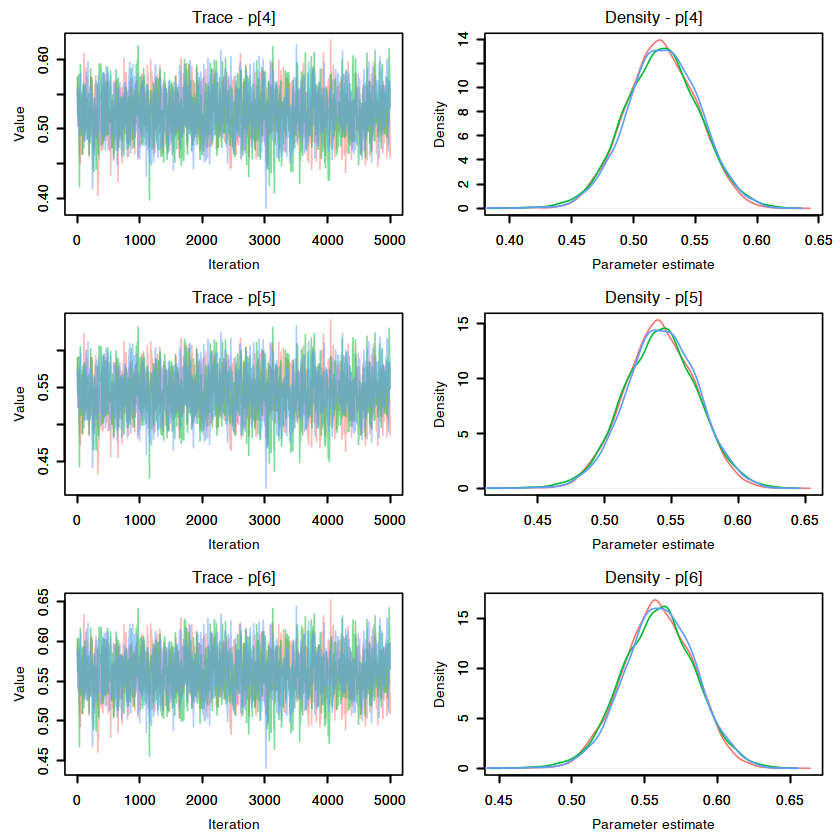

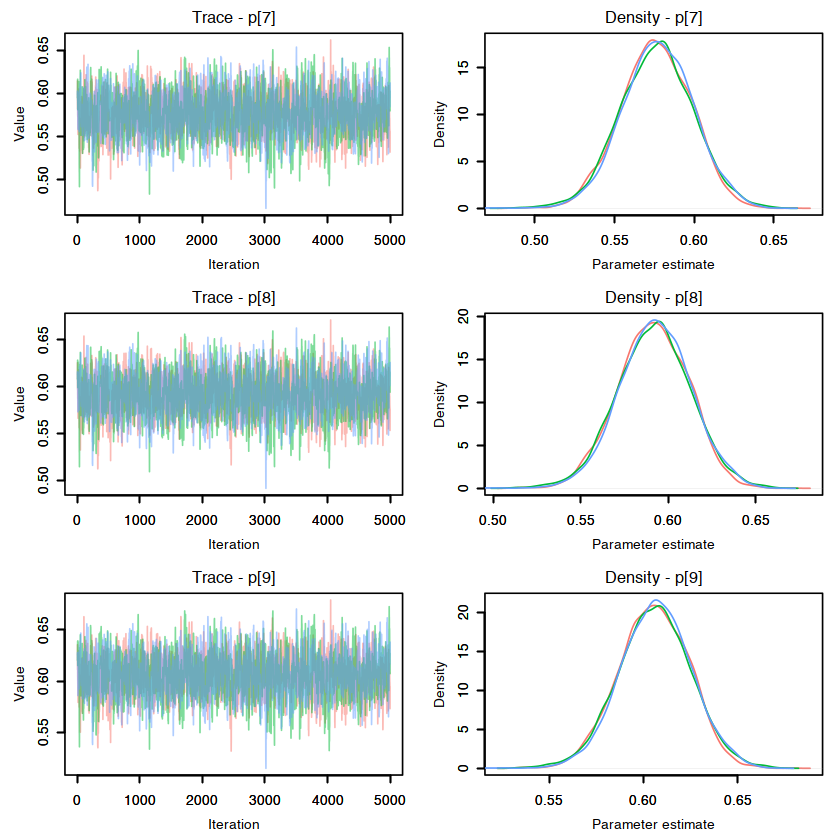

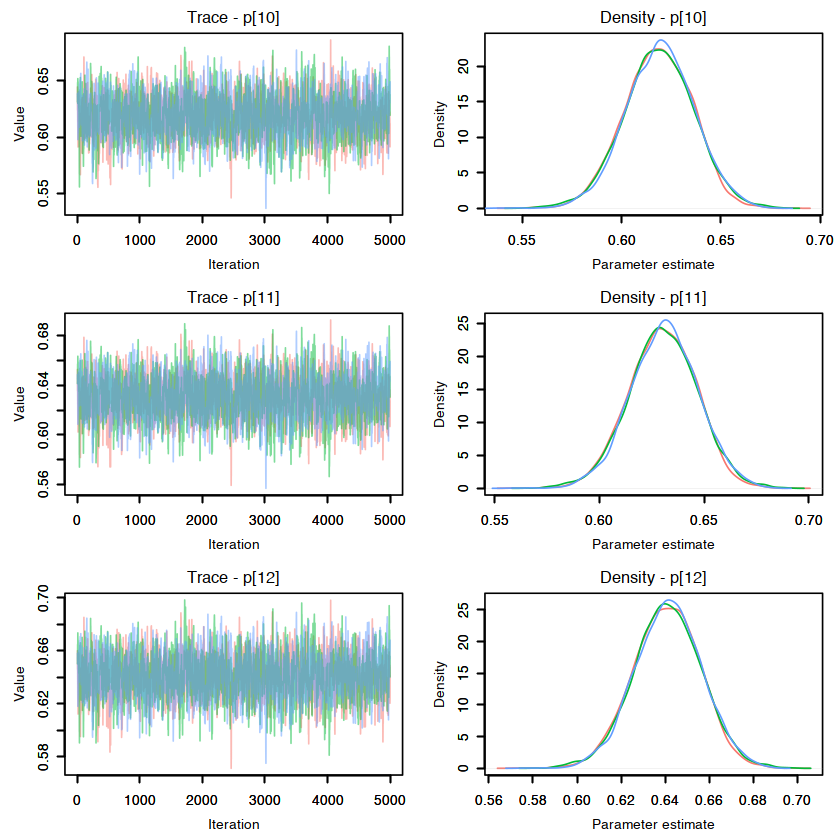

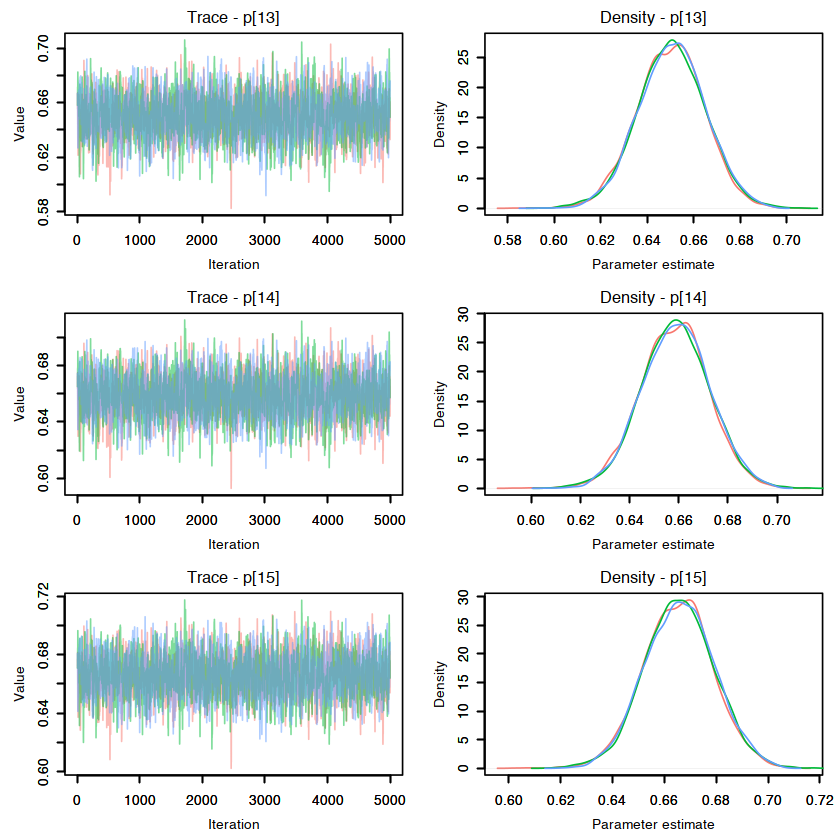

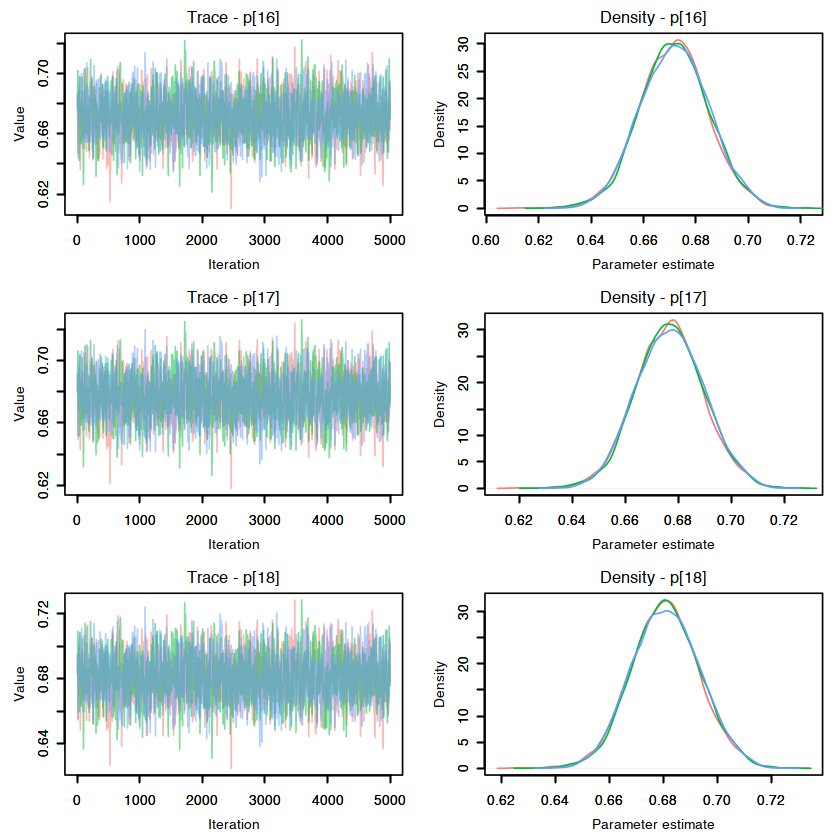

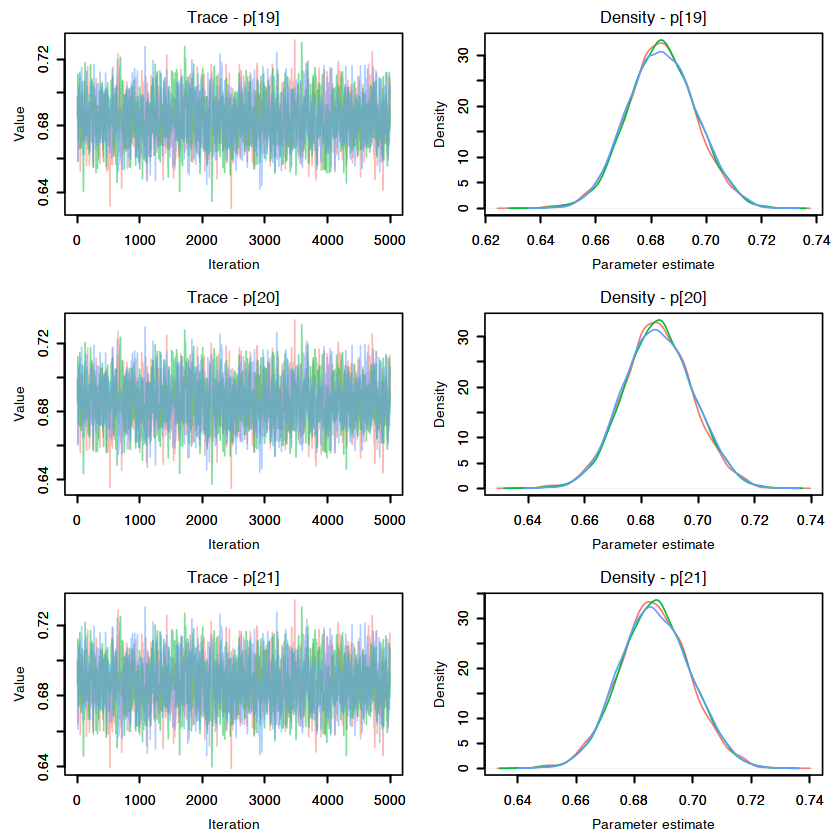

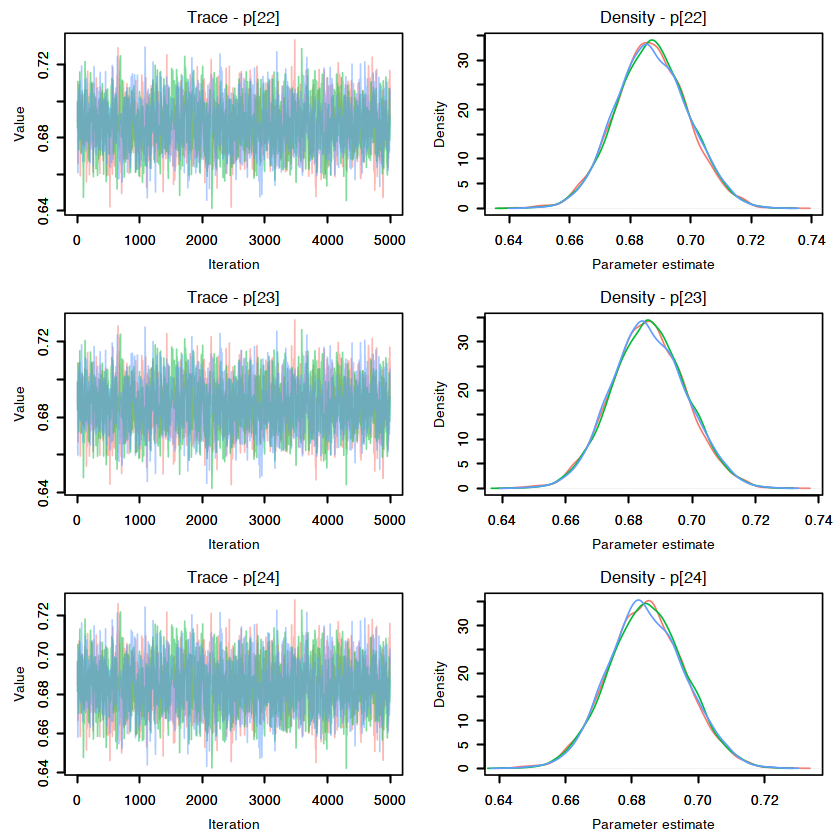

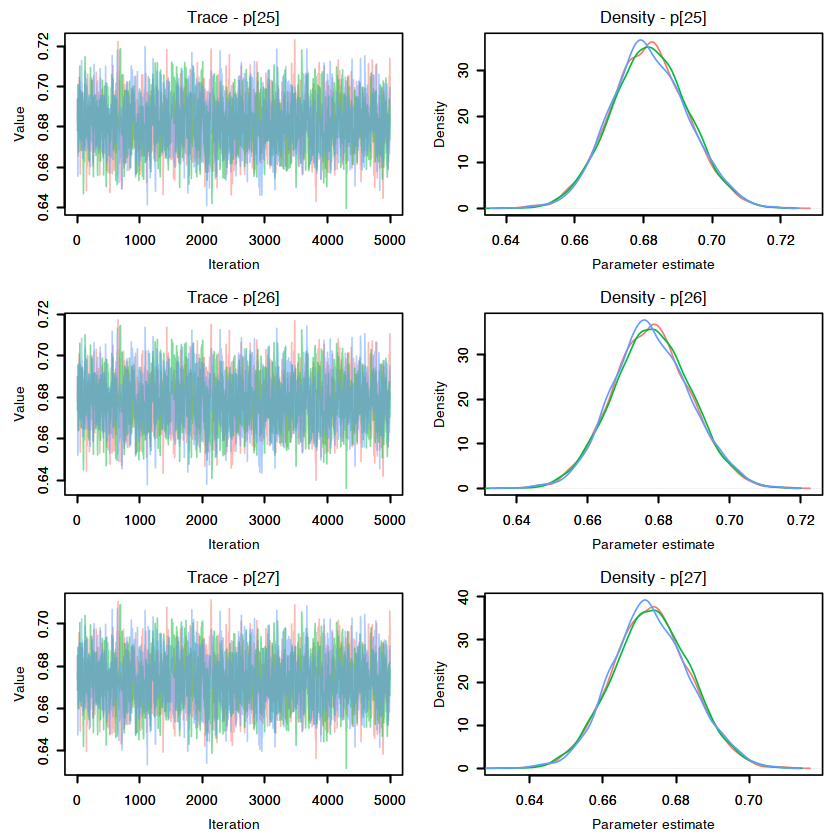

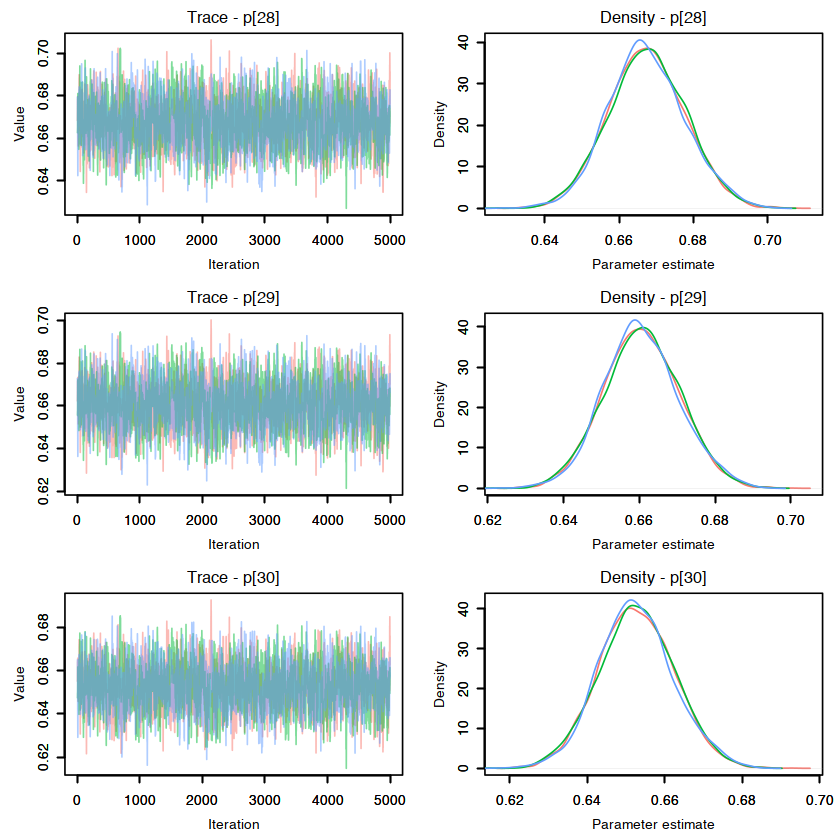

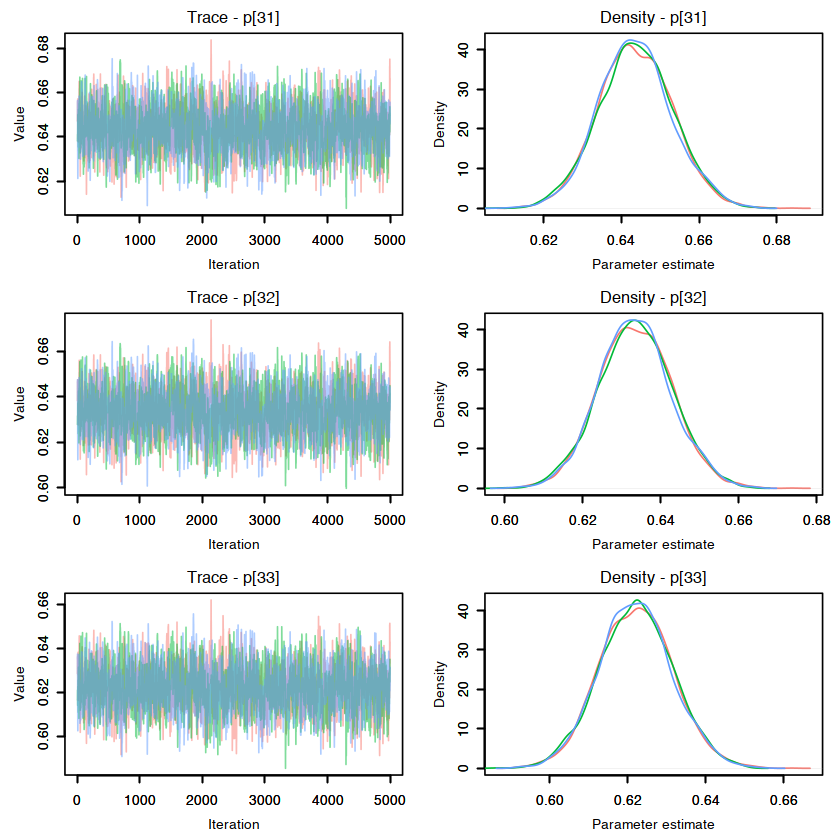

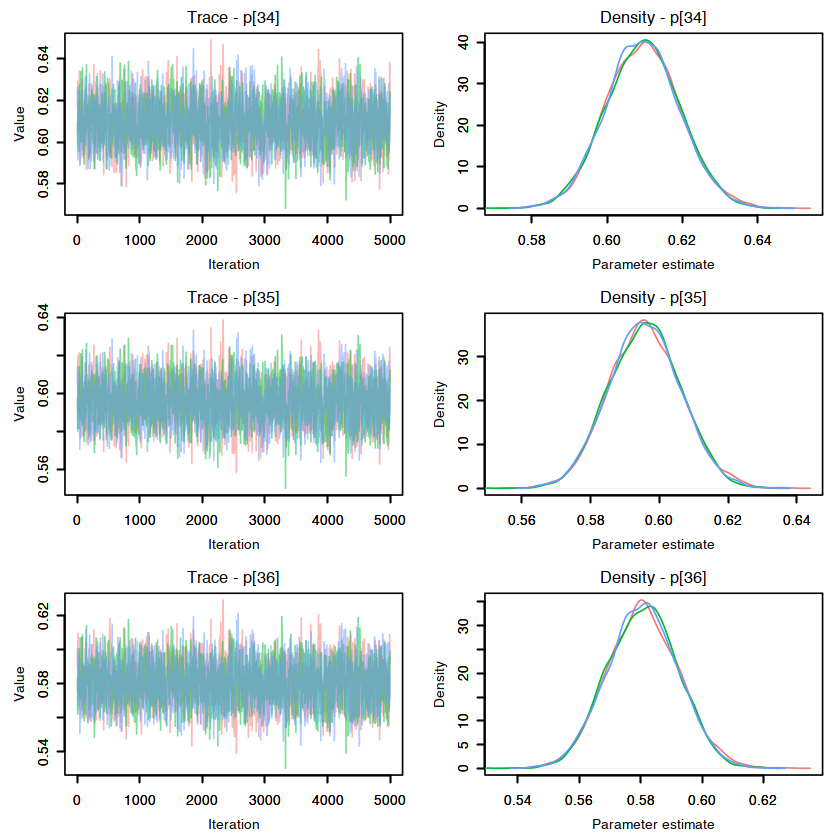

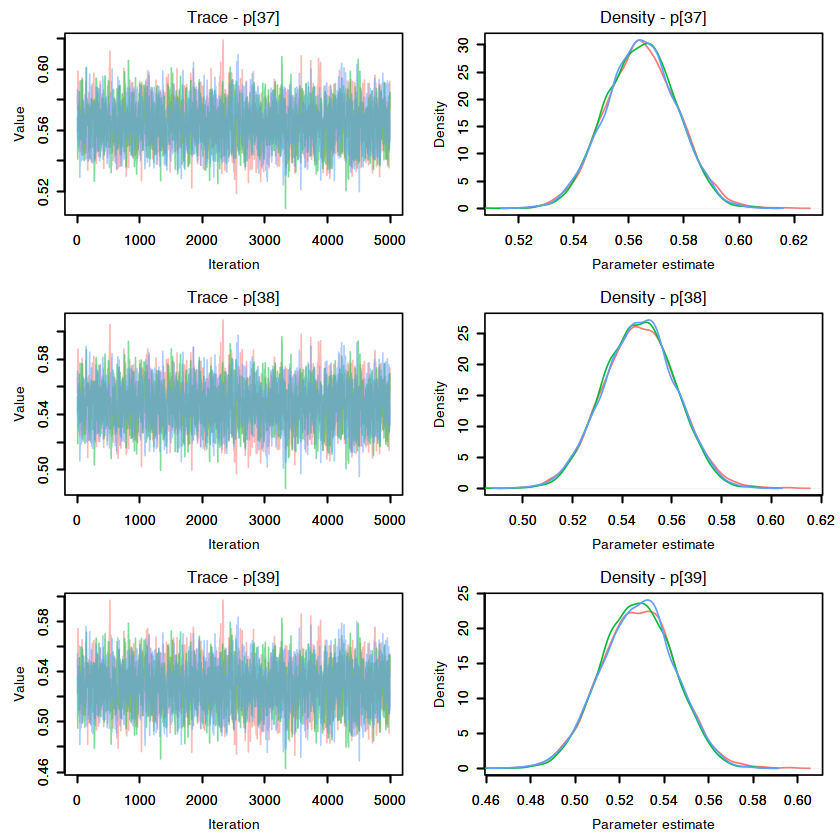

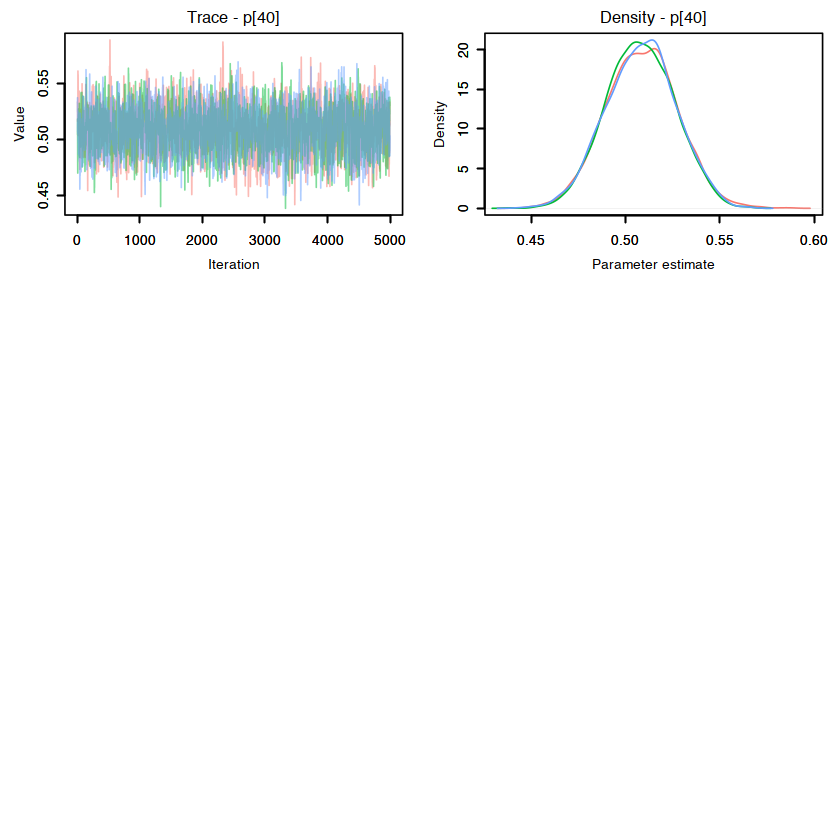

In [13]:
library(MCMCvis)
MCMCtrace(out,            #the fitted model
          params = parms, #out parameters of interest
          ind = TRUE,     #plot chain specific density curves
          pdf = FALSE)    #DON'T write to a PDF

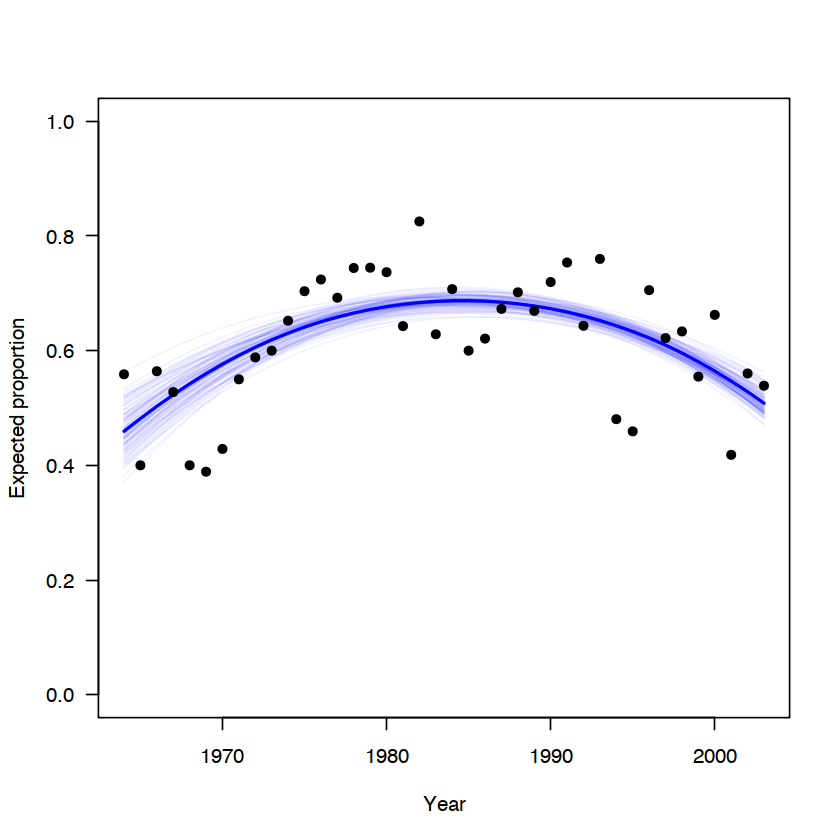

In [17]:
plot(out$mean$p ~ falcons$Year, pch="", ylim=c(0,1),
     ylab="Expected proportion", xlab="Year", las=1) #empty plot

for(i in sample(1:ni,100)){
  lines(out$sims.list$p[i,] ~ falcons$Year, 
        col=adjustcolor("blue",0.05))
}
lines(out$mean$p ~ falcons$Year, col="blue", lwd=2)
points(I(falcons$PairsR/falcons$PairsT) ~ falcons$Year, pch=16)

In [ ]:
n0_chain <- exp(out$sims.list$beta0)
summary(n0_chain)

In [ ]:
hist(n0_chain, col=adjustcolor("gold",0.4), probability = TRUE, las=1) 
lines(density(n0_chain), xlab="Parameter estimate", main = "Expected initial count", lwd=2)
abline(v = c(mean(n0_chain),
             quantile(n0_chain,c(0.025,0.975))),
       lty=c(1,2,2), lwd=c(2,1,1), col="red")

In [14]:
parms2 <- "lambda"
out2 <- jags(data = jagsdat,
             inits = inits,
             parameters.to.save = parms2,   #this is all thats changed!
             model.file = "GLM_Poisson.txt",
             n.chains = nc,
             n.iter = ni,
             n.burnin = nb,
             n.thin = nt)

plot(out2$mean$p ~ falcons$Year, pch="", ylim=c(0,140),
     ylab="Expected count", xlab="Year", las=1) #empty plot

for(i in sample(1:ni,30)){
  lines(out2$sims.list$lambda[i,] ~ falcons$Year, col="grey95")
}
lines(out2$mean$lambda ~ falcons$Year, col="blue", lwd=2)
points(falcons$PairsR ~ falcons$Year, pch=16)


Processing function input....... 

Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 327

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 1000 iterations x 3 chains 
 

Sampling from joint posterior, 5000 iterations x 3 chains 
 

Calculating statistics....... 

Done. 


ERROR: Error in (function (formula, data = NULL, subset = NULL, na.action = na.fail, : invalid type (NULL) for variable 'out2$mean$p'


In [29]:
MCMCsummary(out, round = 4, params = c("beta0","beta1","beta2"))

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta0,-0.1637,0.1520,-0.4614,-0.1635,0.1310,1,2657
beta1,0.9225,0.1412,0.6530,0.9211,1.2011,1,4037
beta2,-0.2236,0.0309,-0.2860,-0.2232,-0.1649,1,5304


In [21]:
successes <- falcons$PairsR
failures <-  falcons$PairsT-falcons$PairsR
falcons$Yr2 <- falcons$Yr^2
binom_glm <- glm(cbind(successes,failures) ~ Yr + Yr2, data = falcons, family = "binomial")
summary(binom_glm)


Call:
glm(formula = cbind(successes, failures) ~ Yr + Yr2, family = "binomial", 
    data = falcons)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6374  -0.7177   0.2706   0.9822   2.8473  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.16265    0.14944  -1.088    0.276    
Yr           0.92023    0.13917   6.612 3.79e-11 ***
Yr2         -0.22301    0.03062  -7.284 3.25e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 160.68  on 39  degrees of freedom
Residual deviance: 104.35  on 37  degrees of freedom
AIC: 292.58

Number of Fisher Scoring iterations: 4


In [ ]:
ml